<a href="https://colab.research.google.com/github/jayaemekar/CSCI-611-AppiledMachineLearning/blob/main/EXAM_TITANIC_NextSteps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EXAM - Spring 2021 - TITANIC
##This Notebook is the second in the set*. The goal here is to Build and Evaluate

*[Assumes you have complete stage 1 (imports, loads, explore data); For stage 2 goals, you should continue explore model generation, exploration, and selection, at your own pace].




IMPORT LIBRARIES

In [373]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Remove warnings
import warnings
warnings.filterwarnings('ignore')


LOAD DATA

In [374]:
#Load the data
titanic = pd.read_csv('/content/titanic_train.csv')
#Print the first 10 rows of data
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Data Exploration/Analysis

In [375]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [376]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


CLEAN DATA

In [377]:
total = titanic.isnull().sum().sort_values(ascending=False)
percent_1 = titanic.isnull().sum()/titanic.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


The Embarked feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the ‘Age’ feature, which has 177 missing values. The ‘Cabin’ feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 77 % of it are missing.

In [378]:
titanic.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

The features contribute to a high survival rate are everything except ‘PassengerId’, ‘Ticket’ and ‘Name’ would be correlated with a high survival rate.

Age Vs Sex

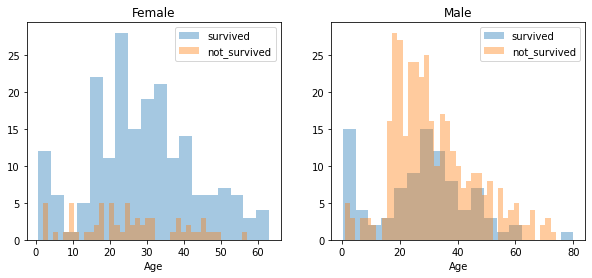

In [379]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = titanic[titanic['Sex']=='female']
men = titanic[titanic['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = 'survived', ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = 'not_survived', ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = 'survived', ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = 'not_survived', ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

In [380]:
#Look at survival rate by sex
titanic.groupby('Sex')[['Survived']].mean()

,Survived
Sex,
female,0.742038
male,0.188908


1. For men have a high probability of survival when they are between 18 and 30 years old.
2. For women the survival chances are higher between 14 and 40.


Embarked, Pclass and Sex:

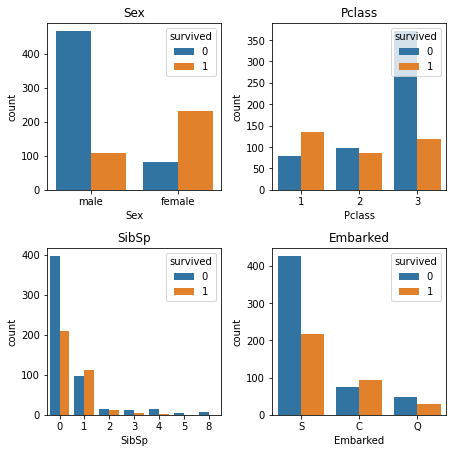

In [381]:
# Visualize the count of survivors for columns  'sex', 'pclass', 'sibsp', 'parch', and 'embarked'
cols = ['Sex', 'Pclass', 'SibSp', 'Embarked']

n_rows = 2
n_cols = 2

# The subplot grid and the figure size of each graph
# This returns a Figure (fig) and an Axes Object (axs)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.2,n_rows*3.2))

for r in range(0,n_rows):
    for c in range(0,n_cols):  
        
        i = r*n_cols+ c #index to go through the number of columns       
        ax = axs[r][c] #Show where to position each subplot
        sns.countplot(titanic[cols[i]], hue=titanic["Survived"], ax=ax)
        ax.set_title(cols[i])
        ax.legend(title="survived", loc='upper right') 
        
plt.tight_layout()   #tight_layout

1. Females are most likely to survive from the chart sex.
2. Third class is most likely to not survive by chart pclass.
3. If you have 0 siblings or spouses on board, you are not likely to survive according to chart sibsp.
4. If you embarked from Southampton (S), you are not likely to survive according to the embarked chart.

In [382]:
#Look at survival rate by sex and class
titanic.pivot_table('Survived', index='Sex', columns='Pclass')

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


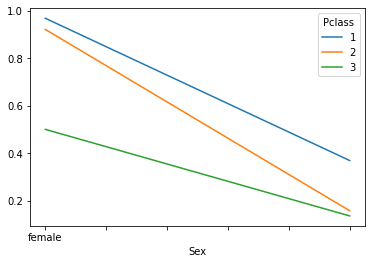

In [383]:
#Look at survival rate by sex and class visually
titanic.pivot_table('Survived', index='Sex', columns='Pclass').plot()


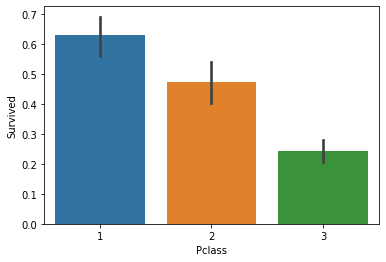

In [384]:
#Plot the survival rate of each class.
sns.barplot(x='Pclass', y='Survived', data=titanic)

In [385]:
#Look at survival rate by sex, age and class
age = pd.cut(titanic['Age'], [0, 18, 80])
titanic.pivot_table('Survived', ['Sex', age], 'Pclass')

Pclass                  1         2         3
Sex    Age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

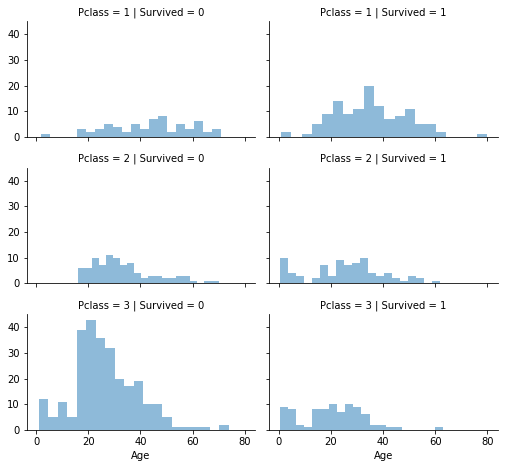

In [386]:
grid = sns.FacetGrid(titanic, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

There is high probability that a person in pclass 3 will not survive.

SibSp and Parch

SibSp and Parch would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic.

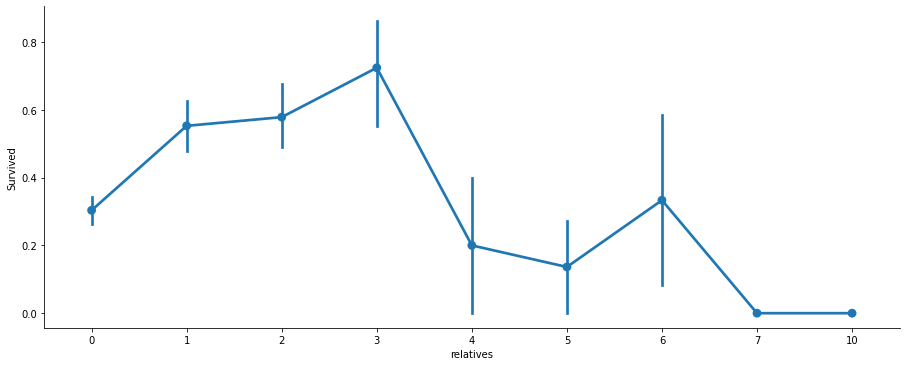

In [387]:
data = [titanic]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
titanic['not_alone'].value_counts()
axes = sns.factorplot('relatives','Survived', 
                      data=titanic, aspect = 2.5, )

It has high probabilty of survival with 1 to 3 realitves, but a lower one if you had less than 1 or more than 3 (except for some cases with 6 relatives).

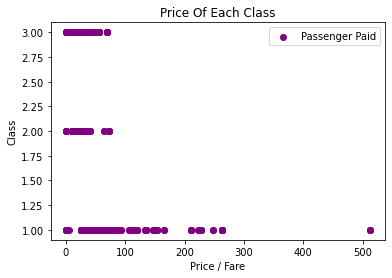

In [388]:
#Plot the Prices Paid Of Each Class
plt.scatter(titanic['Fare'], titanic['Pclass'],  color = 'purple', label='Passenger Paid')
plt.ylabel('Class')
plt.xlabel('Price / Fare')
plt.title('Price Of Each Class')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Survival Probability by Sex and Passenger Class')

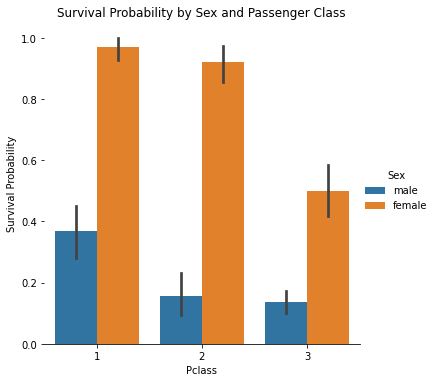

In [389]:
# Survival by gender and passenger class
g = sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = titanic, kind = 'bar')
g.despine(left = True)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Sex and Passenger Class')

In [390]:
# Value counts of the Embarked column 

titanic['Embarked'].value_counts(dropna = False)

# Comment: Two missing values in the Embarked column

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [391]:
# Mean of survival by point of embarkation

titanic[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Text(0.5, 1.0, 'Survival Probability by Point of Embarkation')

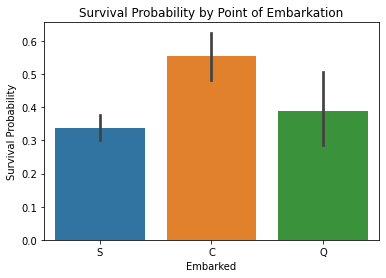

In [392]:
sns.barplot(x = 'Embarked', y ='Survived', data = titanic)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Point of Embarkation')

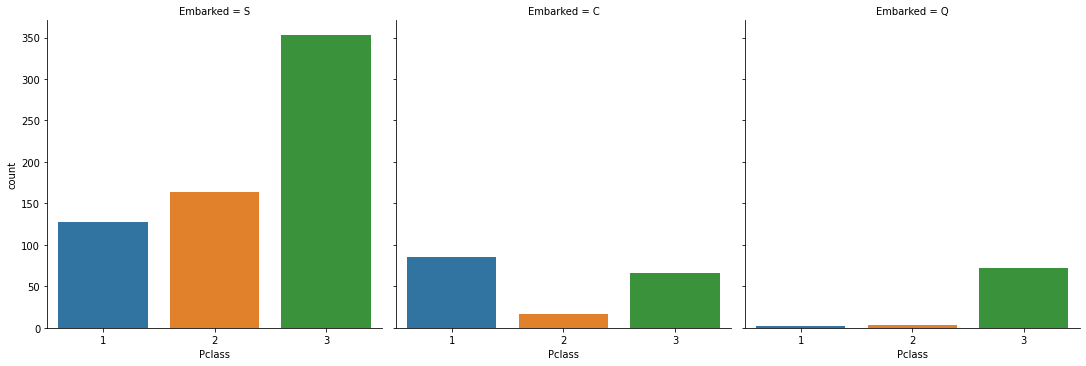

In [393]:
sns.factorplot('Pclass', col = 'Embarked', data = titanic, kind = 'count')

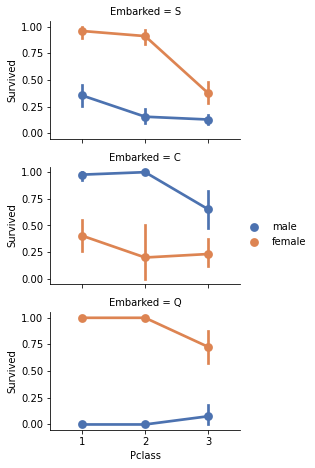

In [394]:
# Survival probability by all categorical variables
grid = sns.FacetGrid(titanic, row = 'Embarked', size = 2.2, aspect = 1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
grid.add_legend()

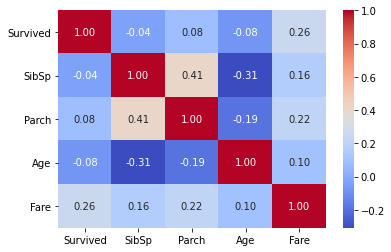

In [395]:

sns.heatmap(titanic[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

# Comment: Fare seems to be the only feature that has a substantial correlation with survival

# Data Preprocessing

I will drop Passenger Id because it doent contribute the persons survival probability and the redundant columns that are non-numerical and remove rows with missing values.

In [396]:
# Drop the columns
titanic = titanic.drop([ 'Name', 'Ticket', 'Cabin','Pclass','PassengerId'], axis=1)

#Remove the rows with missing values
titanic = titanic.dropna(subset =['Embarked', 'Age'])

In [397]:
#Count the NEW number of rows and columns in the data set
titanic.shape

(712, 9)

In [398]:
titanic.dtypes

Survived       int64
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Embarked      object
relatives      int64
not_alone      int64
dtype: object

In [399]:
#Print the unique values in the columns
print(titanic['Sex'].unique())
print(titanic['Embarked'].unique())

['male' 'female']
['S' 'C' 'Q']


In [400]:
#Encoding categorical data values (Transforming object data types to integers)
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

#Encode sex column
titanic.iloc[:,1]= labelencoder.fit_transform(titanic.iloc[:,1].values)
#print(labelencoder.fit_transform(titanic.iloc[:,2].values))

#Encode embarked
titanic.iloc[:,6]= labelencoder.fit_transform(titanic.iloc[:,6].values)
#print(labelencoder.fit_transform(titanic.iloc[:,7].values))

#Print the NEW unique values in the columns
print(titanic['Sex'].unique())
print(titanic['Embarked'].unique())

[1 0]
[2 0 1]


#MODEL BUILDING

In [401]:
#Split the data into independent 'X' and dependent 'Y' variables
X = titanic.iloc[:, 1:8].values 
Y = titanic.iloc[:, 0].values 

Split the data again, this time into 80% training (X_train and Y_train) and 20% testing (X_test and Y_test) data sets.

In [402]:
# Split the dataset into 80% Training set and 20% Testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)


In [403]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

##Try a simple model first - e.g., Logistic Regression

###Train, Test, Evaluate

In [404]:
 #Using Logistic Regression Algorithm to the Training Set
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(random_state = 0)
log.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [405]:
  print('Logistic Regression Training Accuracy:', log.score(X_train, Y_train))

Logistic Regression Training Accuracy: 0.7838312829525483


In [406]:
 # Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, log.predict(X_test)) 
print(cm)
TN, FP, FN, TP = confusion_matrix(Y_test, log.predict(X_test)).ravel()
print('Model[{}] Testing Accuracy = "{} !"'.format('LogisticRegression',  (TP + TN) / (TP + TN + FN + FP)))

[[69 13]
 [21 40]]
Model[LogisticRegression] Testing Accuracy = "0.7622377622377622 !"


# KNeighborsClassifier

In [407]:
#Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [408]:
  print('K Nearest Neighbor Training Accuracy:', knn.score(X_train, Y_train))

K Nearest Neighbor Training Accuracy: 0.843585237258348


In [409]:
 # Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, knn.predict(X_test)) 
print(cm)
TN, FP, FN, TP = confusion_matrix(Y_test, knn.predict(X_test)).ravel()
print('Model[{}] Testing Accuracy = "{} !"'.format('K Nearest Neighbour',  (TP + TN) / (TP + TN + FN + FP)))

[[70 12]
 [19 42]]
Model[K Nearest Neighbour] Testing Accuracy = "0.7832167832167832 !"


# Linear Support Vector Machine 

In [410]:
#Using SVC method of svm class to use Support Vector Machine Algorithm
from sklearn.svm import SVC
svc_lin = SVC(kernel = 'linear', random_state = 0)
svc_lin.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [411]:
 print('Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_train, Y_train))

Support Vector Machine (Linear Classifier) Training Accuracy: 0.7768014059753954


In [412]:
 # Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, svc_lin.predict(X_test)) 
print(cm)
TN, FP, FN, TP = confusion_matrix(Y_test, svc_lin.predict(X_test)).ravel()
print('Model[{}] Testing Accuracy = "{} !"'.format('Support Macine vector',  (TP + TN) / (TP + TN + FN + FP)))

[[70 12]
 [18 43]]
Model[Support Macine vector] Testing Accuracy = "0.7902097902097902 !"


# RBF Support Vector Machine Algorithm

In [413]:
#Using SVC method of svm class to use Kernel SVM Algorithm
from sklearn.svm import SVC
svc_rbf = SVC(kernel = 'rbf', random_state = 0)
svc_rbf.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [414]:
 print('Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(X_train, Y_train))

Support Vector Machine (RBF Classifier) Training Accuracy: 0.8347978910369068


In [415]:
 # Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, svc_rbf.predict(X_test)) 
print(cm)
TN, FP, FN, TP = confusion_matrix(Y_test, svc_rbf.predict(X_test)).ravel()
print('Model[{}] Testing Accuracy = "{} !"'.format('RBF Support Macine vector',  (TP + TN) / (TP + TN + FN + FP)))

[[70 12]
 [18 43]]
Model[RBF Support Macine vector] Testing Accuracy = "0.7902097902097902 !"


# Naïve Bayes Algorithm

In [416]:
#Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
from sklearn.naive_bayes import GaussianNB
gauss = GaussianNB()
gauss.fit(X_train, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [417]:
print('Gaussian Naive Bayes Training Accuracy:', gauss.score(X_train, Y_train))

Gaussian Naive Bayes Training Accuracy: 0.804920913884007


In [418]:
 # Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, gauss.predict(X_test)) 
print(cm)
TN, FP, FN, TP = confusion_matrix(Y_test, gauss.predict(X_test)).ravel()
print('Model[{}] Testing Accuracy = "{} !"'.format('GaussianNB ',  (TP + TN) / (TP + TN + FN + FP)))

[[68 14]
 [21 40]]
Model[GaussianNB ] Testing Accuracy = "0.7552447552447552 !"


#DecisionTreeClassifier 

In [419]:
#Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [420]:
 print('Decision Tree Classifier Training Accuracy:', tree.score(X_train, Y_train))

Decision Tree Classifier Training Accuracy: 0.9929701230228472


In [421]:
 # Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, tree.predict(X_test)) 
print(cm)
TN, FP, FN, TP = confusion_matrix(Y_test, tree.predict(X_test)).ravel()
print('Model[{}] Testing Accuracy = "{} !"'.format('Decision Tree Classifier ',  (TP + TN) / (TP + TN + FN + FP)))

[[66 16]
 [17 44]]
Model[Decision Tree Classifier ] Testing Accuracy = "0.7692307692307693 !"


#RandomForestClassifier 

In [422]:
#Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [423]:
  print('Random Forest Classifier Training Accuracy:', forest.score(X_train, Y_train))

Random Forest Classifier Training Accuracy: 0.9806678383128296


In [424]:
 # Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, forest.predict(X_test)) 
print(cm)
TN, FP, FN, TP = confusion_matrix(Y_test, forest.predict(X_test)).ravel()
print('Model[{}] Testing Accuracy = "{} !"'.format('Random Forest Tree Classifier ',  (TP + TN) / (TP + TN + FN + FP)))

[[63 19]
 [16 45]]
Model[Random Forest Tree Classifier ] Testing Accuracy = "0.7552447552447552 !"


# Stochastic Gradient Descent

In [425]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
forest.fit(X_train, Y_train)
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [426]:
  print('Stochastic Gradient Descent Training Accuracy:', sgd.score(X_train, Y_train))

Stochastic Gradient Descent Training Accuracy: 0.7803163444639719


In [427]:
 # Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, sgd.predict(X_test)) 
print(cm)
TN, FP, FN, TP = confusion_matrix(Y_test, sgd.predict(X_test)).ravel()
print('Model[{}] Testing Accuracy = "{} !"'.format('Stochastic Gradient Descent Classifier ',  (TP + TN) / (TP + TN + FN + FP)))

[[68 14]
 [14 47]]
Model[Stochastic Gradient Descent Classifier ] Testing Accuracy = "0.8041958041958042 !"


# Gradient Boosting Classifier

In [428]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(X_train, Y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [429]:
  print('Gradient Boosting Classifier Training Accuracy:', gbk.score(X_train, Y_train))

Gradient Boosting Classifier Training Accuracy: 0.9050966608084359


In [430]:
 # Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, gbk.predict(X_test)) 
print(cm)
TN, FP, FN, TP = confusion_matrix(Y_test, gbk.predict(X_test)).ravel()
print('Model[{}] Testing Accuracy = "{} !"'.format('Stochastic Gradient Descent Classifier ',  (TP + TN) / (TP + TN + FN + FP)))

[[72 10]
 [16 45]]
Model[Stochastic Gradient Descent Classifier ] Testing Accuracy = "0.8181818181818182 !"


#Perceptron

In [431]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [432]:
  print('Perceptron Training Accuracy:', perceptron.score(X_train, Y_train))

Perceptron Training Accuracy: 0.7363796133567663


In [433]:
 # Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, perceptron.predict(X_test)) 
print(cm)
TN, FP, FN, TP = confusion_matrix(Y_test, perceptron.predict(X_test)).ravel()
print('Model[{}] Testing Accuracy = "{} !"'.format('Perceptron ',  (TP + TN) / (TP + TN + FN + FP)))

[[68 14]
 [21 40]]
Model[Perceptron ] Testing Accuracy = "0.7552447552447552 !"


#Feature Importance

In [434]:
#Get the importance of the features
importances = pd.DataFrame({'feature':titanic.iloc[:, 1:8].columns,'importance':np.round(forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
Fare,0.351
Age,0.305
Sex,0.181
relatives,0.063
Parch,0.039
Embarked,0.036
SibSp,0.024


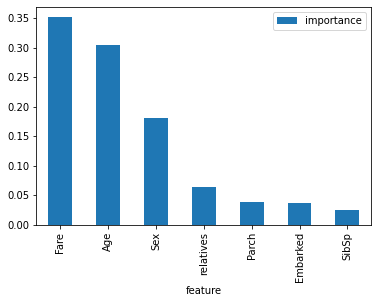

In [435]:
#Visualize the importance
importances.plot.bar()


In [436]:
#Print Prediction of Random Forest Classifier model
pred = forest.predict(X_test)
print(pred)

#Print a space
print()

#Print the actual values
print(Y_test)

[0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0
 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1
 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1]

[0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1
 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1
 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0
 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1]


In [437]:
my_survival = [[1,1,35,0, 0, 0, 1]]
#Print Prediction of Random Forest Classifier model
pred = forest.predict(my_survival)
print(pred)

if pred == 0:
  print('Oh no! You didnt make it')
else:
  print('Nice! You survived')

[0]
Oh no! You didnt make it


###Try to Improve on this model

## Try a more complex model next - e.g., Random Forest

##Try MLPs
### If you have not already done so, try using GridSearchCV to improve your model selection process.

Hyperparameter Tuning